## Equipe
Cleverton Carneiro, Gustavo Cordeiro e Igor Latini

In [1]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
get_ipython().magic(u'matplotlib inline') #para imprimir no próprio notebook

In [2]:
np.random.seed(42)

digits = load_digits()
data = scale(digits.data)

n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target

sample_size = 300


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    predicoes = estimator.fit_predict(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

#Time: tempo gasto na execução
#Inertia: Soma das distâncias, ao quadrado, das amostras até o centro do cluster mais próximo


## Metricas de avaliação
 - **Homogeneity score**: uma clusterização satisfaz homogeidade quando todos seus clusters contém apenas amostras de uma única classe. É um valor entre 0 e 1, sendo 1 = homogêneo. 
 - **Completeness score**: uma clusterização satisfaz completude quando todos as amostras de uma mesma classe estão contidas no mesmo cluster. É um valor entre 0 e 1, sendo 1  = completo.
 - **V measure score**: média harmônica entre homogeneidade e completude. É um valor entre 0 e 1, sendo 1 = homogeneidade e completude máximas. É calculada de acordo com a fórmula (beta passado como parâmetro, igual a 1 por padrão): 
    - v = (1 + beta) * homogeneity * completeness/ (beta * homogeneity + completeness)
 - **Adjusted rand score**: Rand Index (RI) ajustado levando em conta o acaso. RI computa a similaridade entre duas clusterizações, através de duplas de amostras, verificando se foram colocadas no mesmo cluster ou em clusters diferentes. É um valor entre -1 e 1, sendo que próximo a zero indica uma "labelização" aleatória, e 1 uma similaridade máxima. Para ser ajustada considerando o acaso, é usado:
     - ARI = (RI - Expected_RI) / (max(RI) - Expected_RI)
 - **Adjusted mutual info score (AMI)**: Mutual Information (MI) ajustada para levar em consideração o acaso. MI é normalmente alta para duas clusterizações com muitos clusters, mesmo que não haja tanta informação compartilhada. É um valor limitado em 1, sendo que 1 indica que os dois clusters são perfeitamente iguais, enquanto proximidade de 0 indica uma separação independente. É calculada com (U e V são clusters):
     - AMI(U, V) = [MI(U, V) - E(MI(U, V))] / [avg(H(U), H(V)) - E(MI(U, V))]
 - **Silhouette score**: computa a média do coeficiente de silhueta de todas as amostras. O coeficiente de silhueta de cada amostra é calculado usando a distância média intra-cluster (a) e a distância média ao cluster mais próximo (cluster que a amostra não faz parte). Basicamente, avalia o quanto uma amostra pertence ao seu próprio cluster comparado aos outros clusters. É um valor entre -1 e 1, sendo -1 o pior valor e 1 o melhor. Zero indica que há "overlap" entre clusters, e valores negativos em geral indicam que a amostra foi atribuída a um cluster errado. Para calcular o coeficiente de silhueta de cada amostra, é usado (b - a) / max(a, b).

Observando os resultados, é possível notar que as métricas de avaliação estão bem próximas para todos os inicializadores do k-means. Entretanto, o uso do PCA acelerou a execução do código, consumindo um tempo consideravelmente menor que os outros.

n_digits: 10, 	 n_samples 1797, 	 n_features 64
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	1.19s	69661	0.670	0.709	0.689	0.557	0.667	0.129
random   	0.39s	69657	0.674	0.715	0.694	0.558	0.671	0.136
PCA-based	0.14s	70679	0.676	0.705	0.690	0.560	0.672	0.119
__________________________________________________________________________________


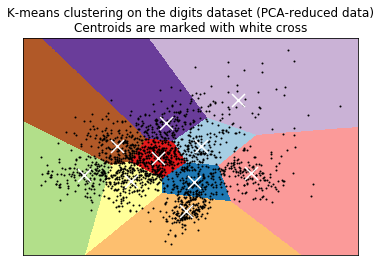

In [3]:

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')


bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(82 * '_')

# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()


# Método "Elbow"

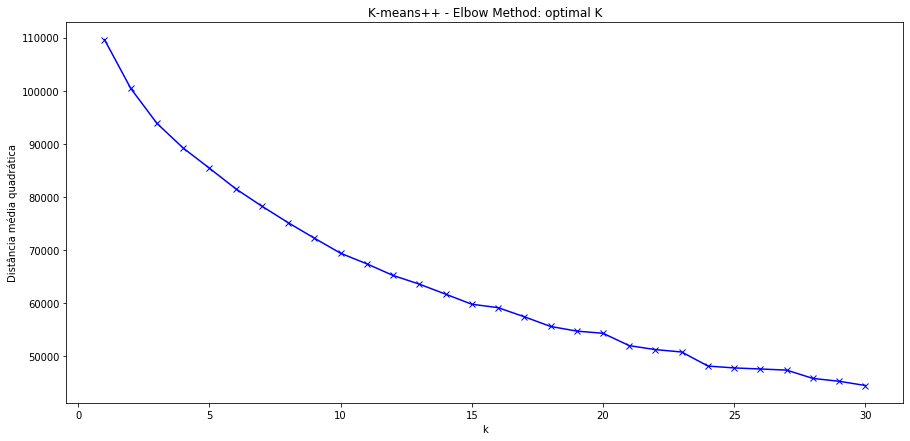

In [25]:
#k-means++
sse = []
K = np.arange(1,31)
for k in K:
    estimator = KMeans(init='k-means++', n_clusters=k)
    estimator.fit(data)
    sse.append(estimator.inertia_)
    
plt.figure(figsize=(15,7))
plt.plot(K, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('Distância média quadrática')
plt.title('K-means++ - Elbow Method: optimal K')
plt.show()

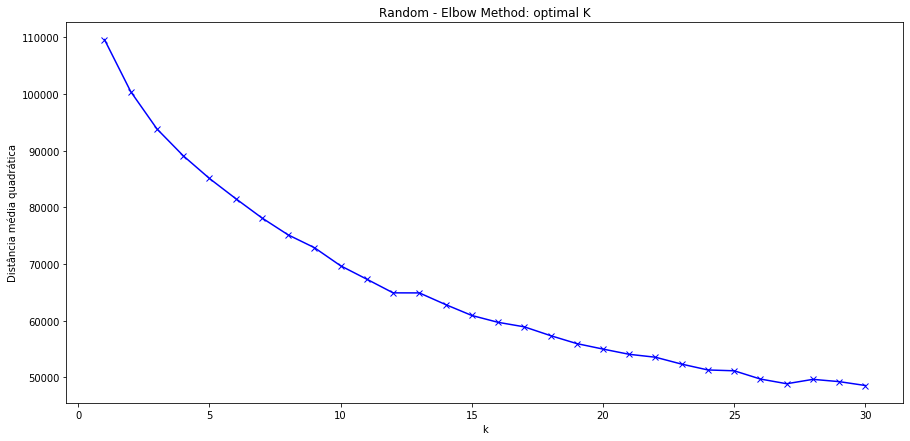

In [26]:
#random
sse_rand = []
K = np.arange(1,31)
for k in K:
    estimator = KMeans(init='random', n_clusters=k)
    estimator.fit(data)
    sse_rand.append(estimator.inertia_)
    
plt.figure(figsize=(15,7))
plt.plot(K, sse_rand, 'bx-')
plt.xlabel('k')
plt.ylabel('Distância média quadrática')
plt.title('Random - Elbow Method: optimal K')
plt.show()

Visualmente poderíamos dizer que o melhor __k__ é algo em torno de 12. Porém, isso não está muito claro no gráfico. 
Como alternativa vamos analisar o coeficiente de Silhouette. A análise por Silhouette mede o quão bem um ponto se encaixa em um cluster.


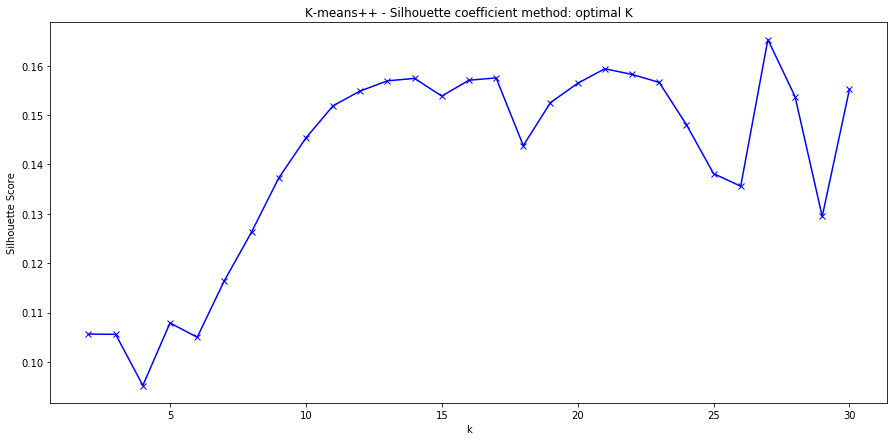

In [29]:
from sklearn.metrics import  silhouette_score
#k-means++
ss_avg = []
K = np.arange(2,31)
for k in K:
    estimator = KMeans(init='k-means++', n_clusters=k)
    cluster_labels = estimator.fit_predict(data)
    silhouette_avg = silhouette_score(data, cluster_labels)
    
    ss_avg.append(silhouette_avg)
    
plt.figure(figsize=(15,7))
plt.plot(K, ss_avg, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('K-means++ - Silhouette coefficient method: optimal K')
plt.show()


Melhor __k__ = 27

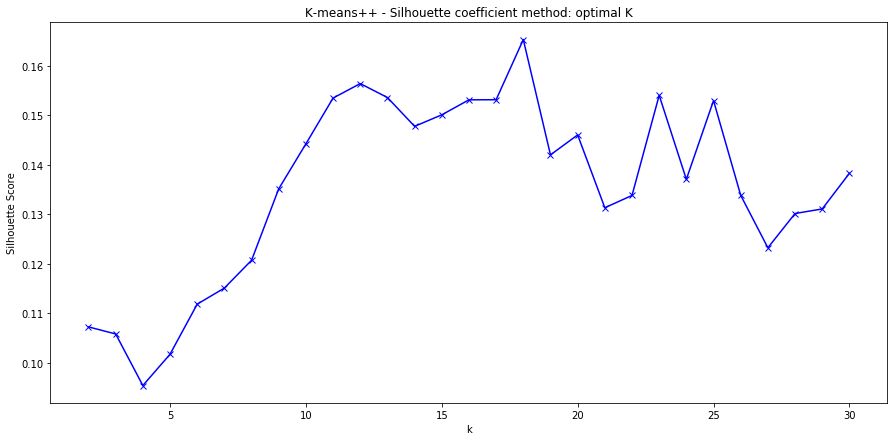

In [28]:
from sklearn.metrics import  silhouette_score
#k-means++
ss_rand_avg = []
K = np.arange(2,31)
for k in K:
    estimator = KMeans(init='random', n_clusters=k)
    cluster_labels = estimator.fit_predict(data)
    silhouette_avg = silhouette_score(data, cluster_labels)
    
    ss_rand_avg.append(silhouette_avg)
    
plt.figure(figsize=(15,7))
plt.plot(K, ss_rand_avg, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('K-means++ - Silhouette coefficient method: optimal K')
plt.show()

Melhor k = 18

Importante observar que a base possui 10 dígitos distintos. 